In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [48]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx')

df = df.set_index('index')

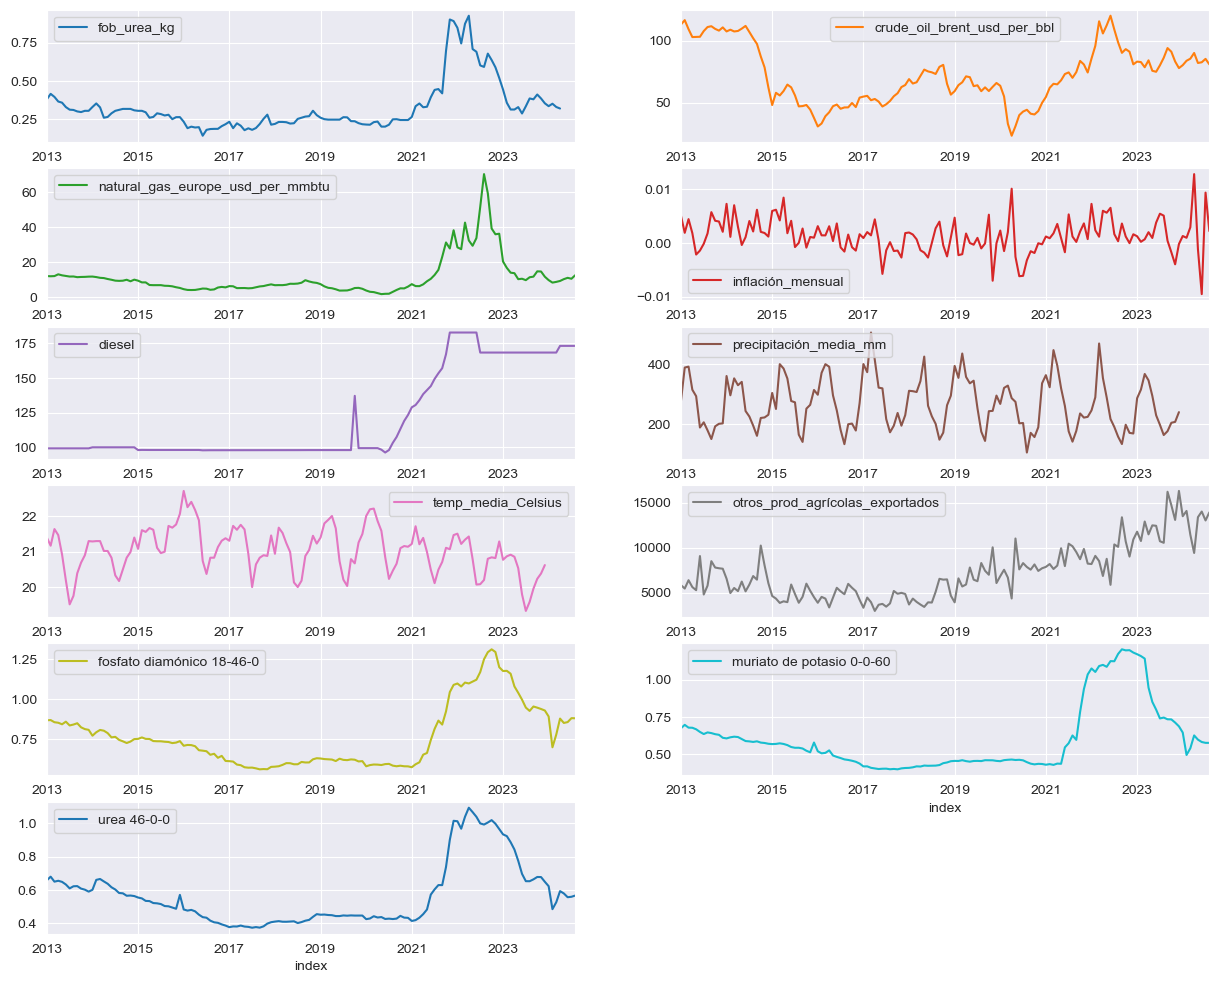

In [49]:
num_de_filas = ((df.shape[1] + 1) // 2)

df.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

In [50]:
# Extraer variables predictoras:
X = df.drop(columns=['fosfato diamónico 18-46-0', 'muriato de potasio 0-0-60', 'urea 46-0-0'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0'

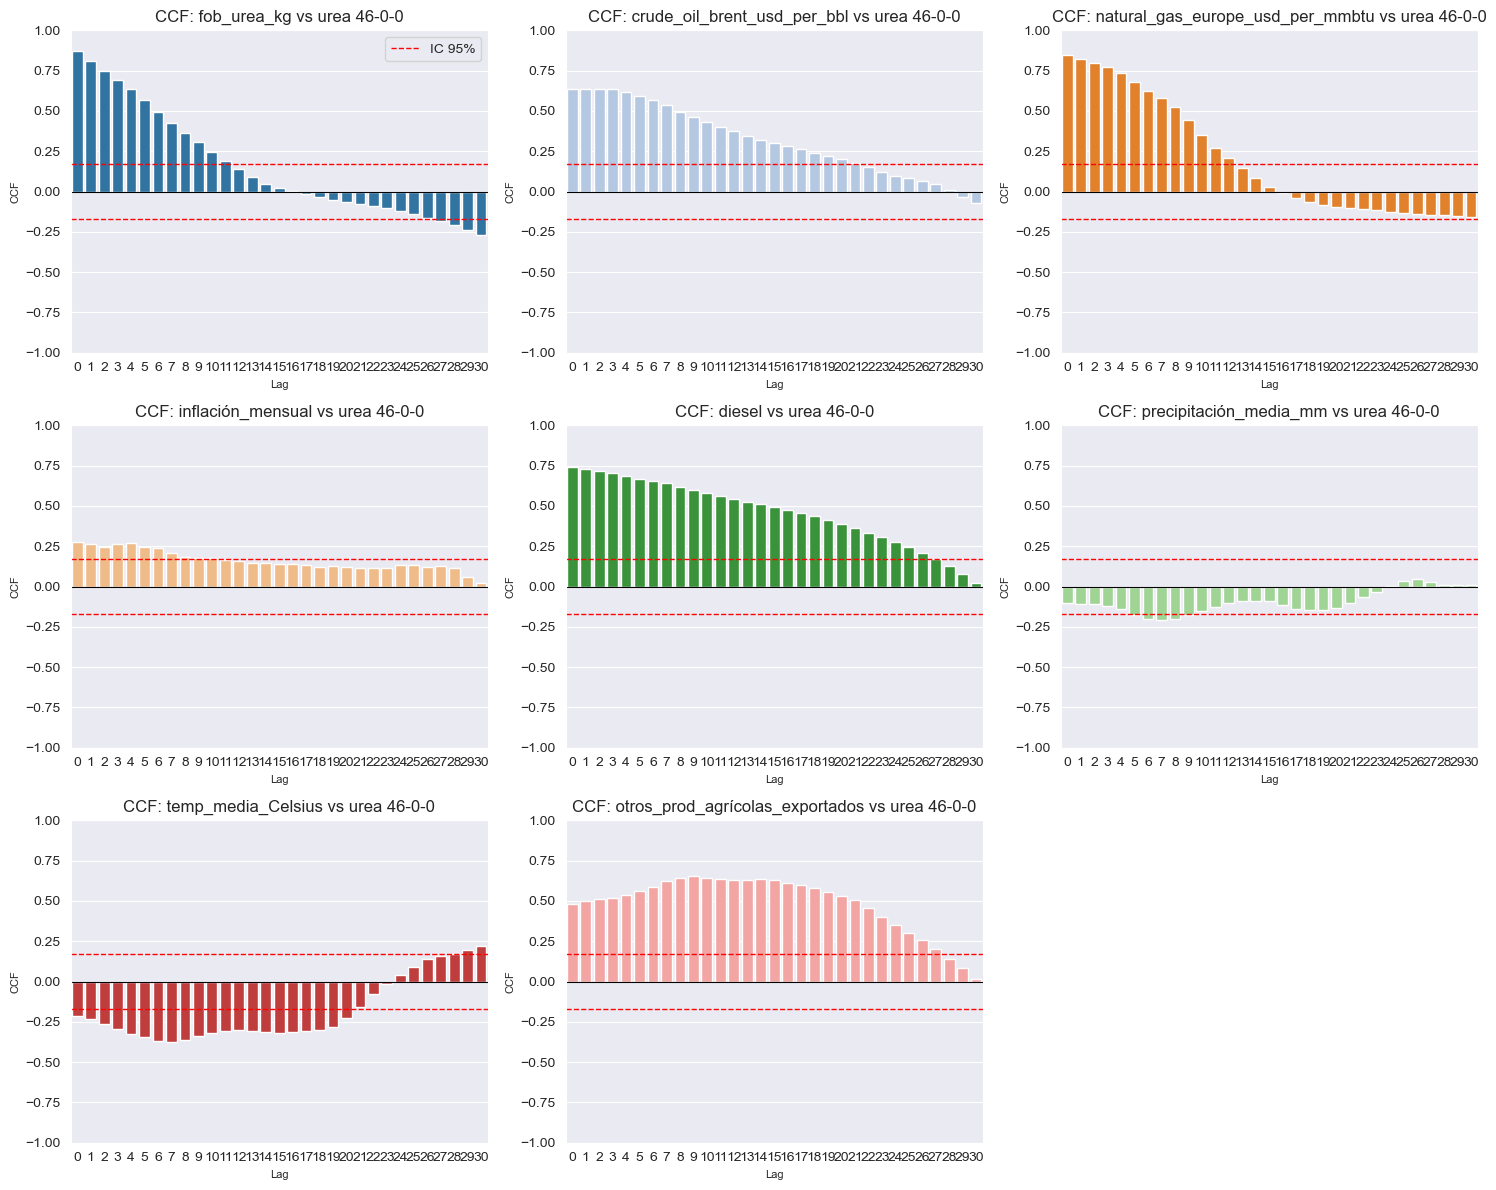

In [51]:
# Uso de la función
plot_ccf_subplots(df, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")


### Diferenciación no-estacional y estacional

#### Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*

In [52]:
df_sin_na = df.dropna()

df_test_estacionareidad = evaluar_estacionareidad(df_estacionario)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.361962e-01,0.022258,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.067201e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.756353e-01,0.031976,False,True,No estacionario
3,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
4,diesel,9.639810e-01,0.010000,False,True,No estacionario
5,precipitación_media_mm,1.298639e-01,0.100000,False,False,No claro
6,temp_media_Celsius,5.043799e-01,0.100000,False,False,No claro
7,otros_prod_agrícolas_exportados,9.990506e-01,0.010000,False,True,No estacionario
8,fosfato diamónico 18-46-0,3.972852e-01,0.023077,False,True,No estacionario
9,muriato de potasio 0-0-60,4.079042e-01,0.019878,False,True,No estacionario


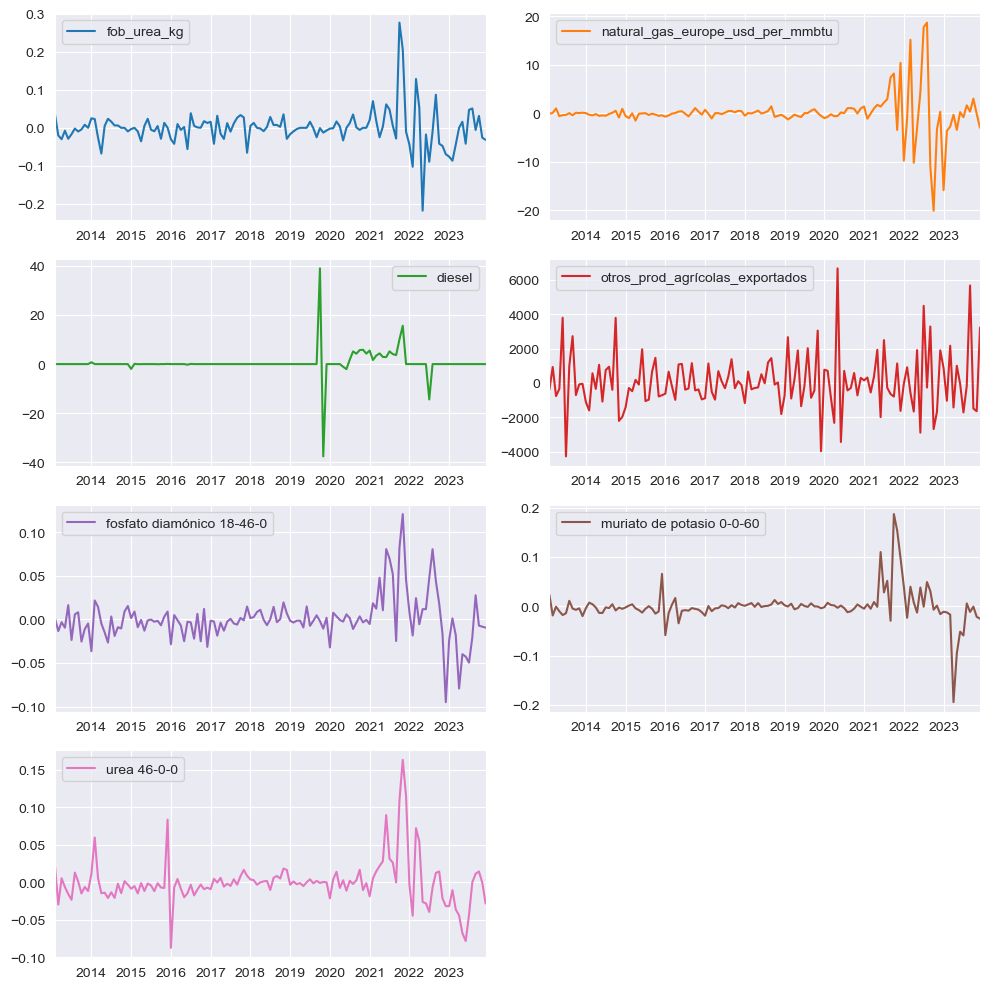

In [53]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

variables_no_estacionarias = df_test_estacionareidad.query("estado_estacionario == 'No estacionario'")['variable'].values

df_no_estacionarias = df_sin_na[variables_no_estacionarias]

df_diferenciadas = pd.DataFrame(index=pd.date_range(start='2013-02', end='2024-01', freq='ME'))

for col in variables_no_estacionarias:
    
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_no_estacionarias[col])
    
    df_diferenciadas[col] = np.diff(df_no_estacionarias[col], n=d)

df_diferenciadas.plot(
    subplots=True,
    layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()